In [1]:
compression_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]

In [2]:
def round_to_nearest_ratio(number, ratios, num_dec_pts=2):
    ratios.sort()
    if number <= ratios[0]:
        return ratios[0]
    if number >= ratios[-1]:
        return ratios[-1]

    for i in range(len(ratios) - 1):
        if ratios[i] < number <= ratios[i + 1]:
            val_1 = round(number - ratios[i], num_dec_pts)
            val_2 = round(ratios[i + 1] - number, num_dec_pts)

            if val_1 == val_2:
                return ratios[i + 1]
            else:
                min_val = round(min(val_1, val_2), num_dec_pts)

                if min_val == val_1:
                    return ratios[i]
                elif min_val == val_2:
                    return ratios[i + 1]


In [3]:
degrees = [x for x in range(5)]

In [1]:
from data_utils import load_ucr_archive

ts_lengths = [(50, 199), (200, 499), (500, 799)]
all_data = []
all_compression_ratios = []
for min_length, max_length in ts_lengths:
    all_data.append(load_ucr_archive(min_length, max_length))
    min_compression_ratio = (max(degrees) + 1) / min_length
    if (min_compression_ratio < min(compression_ratios)) & (min_compression_ratio not in compression_ratios):
        all_compression_ratios.append([min_compression_ratio] + compression_ratios)
    else:
        print("compression ratio either too small or already present")
        all_compression_ratios.append(compression_ratios)
        print(min_compression_ratio)
print(*all_compression_ratios)
    

Could not fetch file number 2. Error: only length-1 arrays can be converted to Python scalars


TypeError: 'NoneType' object is not iterable

In [5]:
for data in all_data:
    print("number of time series:", len(data.index))

number of time series: 22636
number of time series: 7954
number of time series: 13912


In [6]:
"""from data_utils import load_ucr_archive, load_ucr_dataset
import seaborn as sns
data = load_ucr_archive(min_ts_length=80,max_ts_length=1000)
ts_lengths = [len(x[1]['data']) for x in data.iterrows()]
print(ts_lengths)
sns.displot(ts_lengths)

data = load_ucr_dataset(2)

data.head()"""


"from data_utils import load_ucr_archive, load_ucr_dataset\nimport seaborn as sns\ndata = load_ucr_archive(min_ts_length=80,max_ts_length=1000)\nts_lengths = [len(x[1]['data']) for x in data.iterrows()]\nprint(ts_lengths)\nsns.displot(ts_lengths)\n\ndata = load_ucr_dataset(2)\n\ndata.head()"

In [7]:
%%time
from plot import plot_splines
from spline_utils import generate_coeff_counts, generate_knot_vector_from_coeff_count
from fit import fit_max_spline, fit_max_l1_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from spline_utils import evaluate_spline
import pandas as pd
import matplotlib.pyplot as plt

data = all_data[1]
print("number of time series:", len(data.index))
compression_ratios = all_compression_ratios[1]
results = []
error_ts = []
counter = 0
for index, row in data.iterrows():
    time_series = row['data']
    print(row['dataset'], "no.", row['num'], "len(ts):", len(time_series), "ts processed:",
          round(counter / len(data.index), 4) * 100, "%")
    counter += 1
    for degree in degrees:
        #counts = generate_knot_counts(num_data_pts=len(time_series), degree=degree, compression_ratios=compression_ratios)
        counts = generate_coeff_counts(num_data_pts=len(time_series), degree=degree,
                                       compression_ratios=compression_ratios)
        for count in counts:
            #knots = generate_knot_vector(degree=degree, num_knots=count)
            knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=count)

            #max_dist, result = fit_max_l1_spline(time_series, knots, degree, eps=0.0000001)
            max_dist, result = fit_max_spline(time_series, knots, degree)

            # calculate error measures
            fitted_spline = [evaluate_spline(knots, result, degree, x[0]) for x in time_series]
            mse = mean_squared_error(fitted_spline, [x[1] for x in time_series])
            mae = mean_absolute_error(fitted_spline, [x[1] for x in time_series])

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'degree': degree,
                'num_data_pts': len(time_series),
                'num_coeffs': count,
                'compression_rate': round_to_nearest_ratio(count / len(time_series), ratios=compression_ratios),
                'max_dist': max_dist,
                'MSE': mse,
                'MAE': mae
            })

            #plot_splines(plt, knots, degree, time_series)
            #plt.show()


number of time series: 7954
AllGestureWiimoteX no. 0 len(ts): 200 ts processed: 0.0
AllGestureWiimoteX no. 17 len(ts): 329 ts processed: 0.0
AllGestureWiimoteX no. 22 len(ts): 241 ts processed: 0.0
AllGestureWiimoteX no. 23 len(ts): 226 ts processed: 0.0
AllGestureWiimoteX no. 30 len(ts): 202 ts processed: 0.0
AllGestureWiimoteX no. 31 len(ts): 218 ts processed: 0.0
AllGestureWiimoteX no. 32 len(ts): 385 ts processed: 0.0
AllGestureWiimoteX no. 33 len(ts): 278 ts processed: 0.0
AllGestureWiimoteX no. 34 len(ts): 281 ts processed: 0.0
AllGestureWiimoteX no. 35 len(ts): 266 ts processed: 0.0
AllGestureWiimoteX no. 36 len(ts): 332 ts processed: 0.0
AllGestureWiimoteX no. 42 len(ts): 312 ts processed: 0.0
AllGestureWiimoteX no. 43 len(ts): 209 ts processed: 0.0
AllGestureWiimoteX no. 46 len(ts): 236 ts processed: 0.0
AllGestureWiimoteX no. 47 len(ts): 279 ts processed: 0.0
AllGestureWiimoteX no. 59 len(ts): 278 ts processed: 0.0
AllGestureWiimoteX no. 65 len(ts): 296 ts processed: 0.0
AllG

ValueError: Invalid input for linprog: b_ub must not contain values inf, nan, or None

In [17]:
df = pd.DataFrame(results)
df

,dataset,num,degree,num_data_pts,num_coeffs,compression_rate,max_dist,MSE,MAE
0,AllGestureWiimoteX,0,0,200,5,0.025,2.253679,2.292291,1.412397
1,AllGestureWiimoteX,0,0,200,20,0.100,1.652177,1.717924,1.242453
2,AllGestureWiimoteX,0,0,200,40,0.200,1.050676,0.755404,0.818238
3,AllGestureWiimoteX,0,0,200,60,0.300,0.902253,0.608741,0.745980
4,AllGestureWiimoteX,0,0,200,80,0.400,0.902253,0.658676,0.785194
...,...,...,...,...,...,...,...,...,...
43345,DodgerLoopDay,15,4,288,28,0.100,1.119795,0.411710,0.540252
43346,DodgerLoopDay,15,4,288,57,0.200,1.091009,0.513994,0.612239
43347,DodgerLoopDay,15,4,288,86,0.300,0.915455,0.446267,0.600416
43348,DodgerLoopDay,15,4,288,115,0.400,0.850400,0.426446,0.582839


# PLOTS

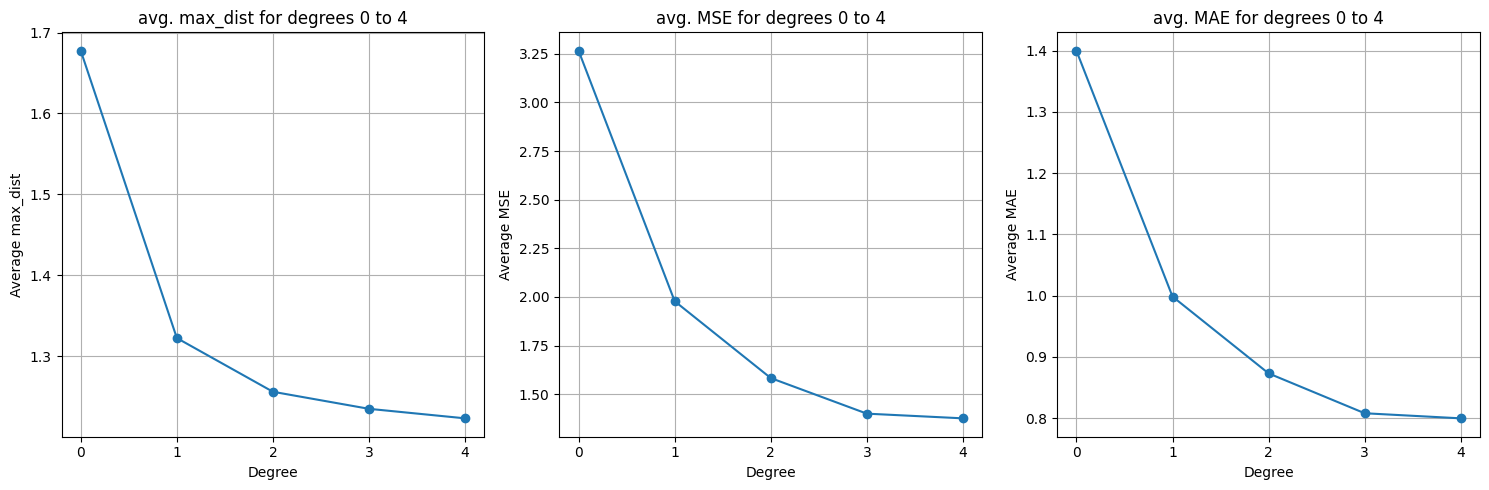

In [14]:
import matplotlib.pyplot as plt

metrics = ['max_dist', 'MSE', 'MAE']
# the same but plotting the graphs next to each other
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_metric_by_degree = df.groupby('degree')[metric].mean()
    axs[i].plot(avg_metric_by_degree.index, avg_metric_by_degree.values, marker='o', linestyle='-')
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Average ' + metric)
    axs[i].set_title('avg. ' + metric + ' for degrees 0 to ' + str(max(df['degree'].unique())))
    axs[i].set_xticks(list(avg_metric_by_degree.index))
    axs[i].grid(True)

plt.tight_layout()
plt.show()

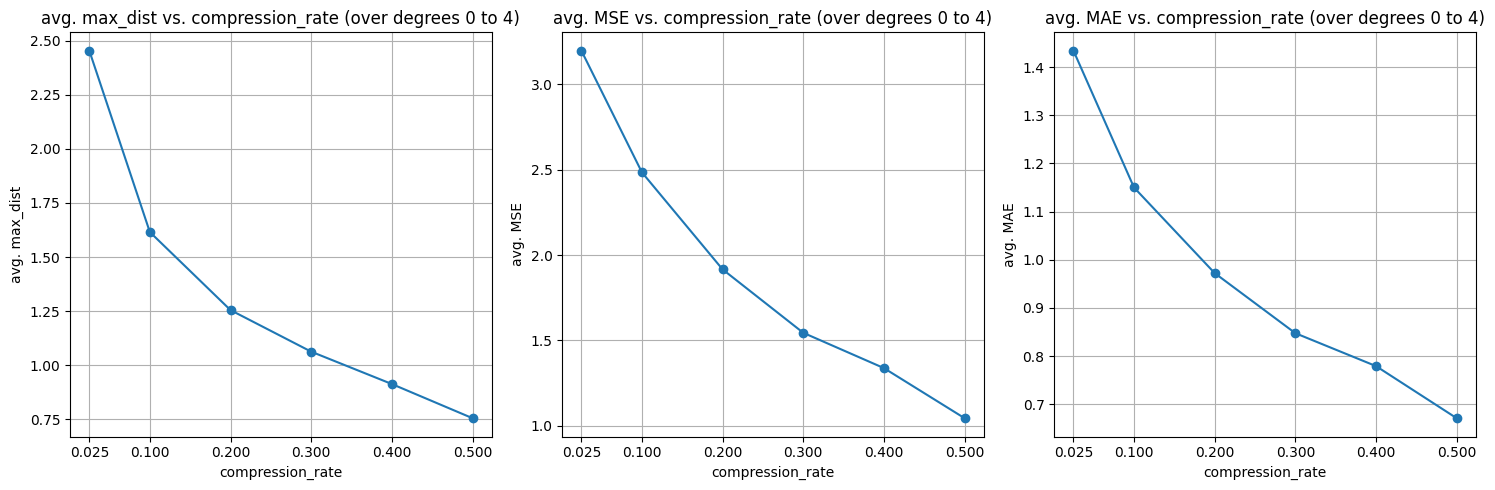

In [15]:
# avg max_dist/mse/mae (accuracy whatever) vs compression rate (avg. over all degrees)
avg_mse_by_compression_rate = df.groupby('compression_rate')['max_dist'].mean()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, metric in enumerate(metrics):
    avg_mse_by_compression_rate = df.groupby('compression_rate')[metric].mean()
    axs[i].plot(avg_mse_by_compression_rate.index, avg_mse_by_compression_rate.values, marker='o', linestyle='-')
    axs[i].set_xlabel('compression_rate')
    axs[i].set_ylabel('avg. ' + metric)
    axs[i].set_title(
        'avg. ' + metric + ' vs. compression_rate (over degrees 0 to ' + str(max(df['degree'].unique())) + ')')
    axs[i].set_xticks(compression_ratios)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

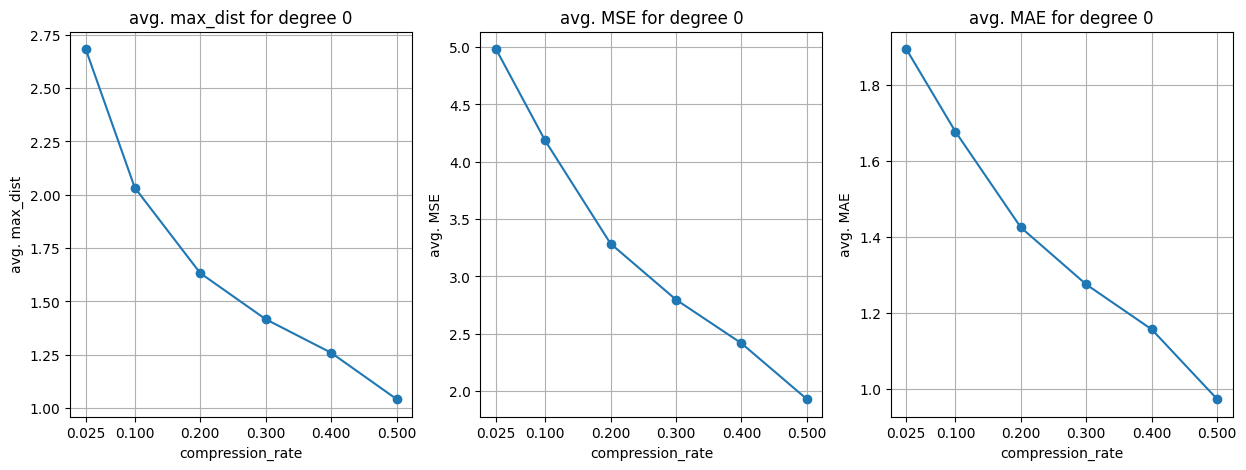

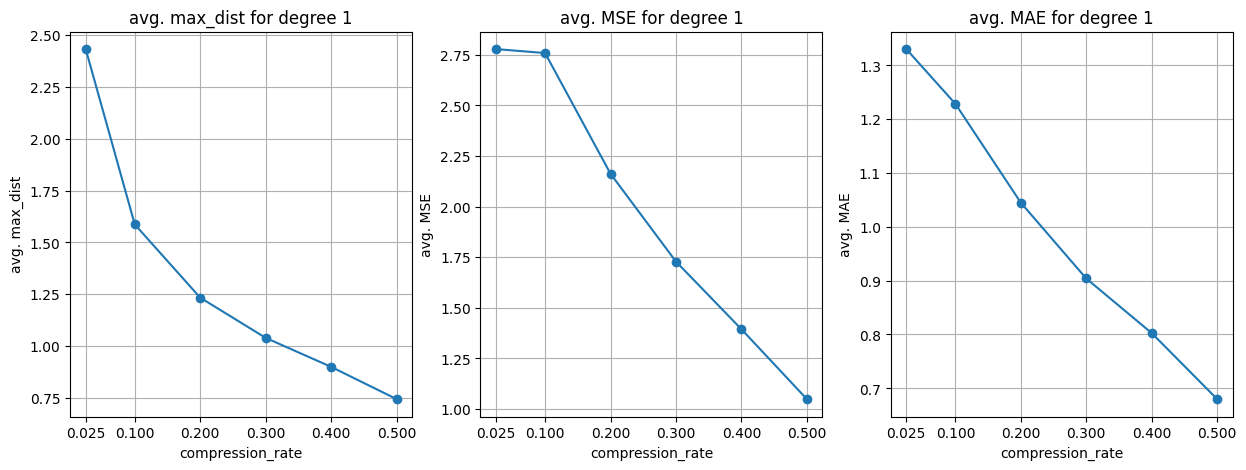

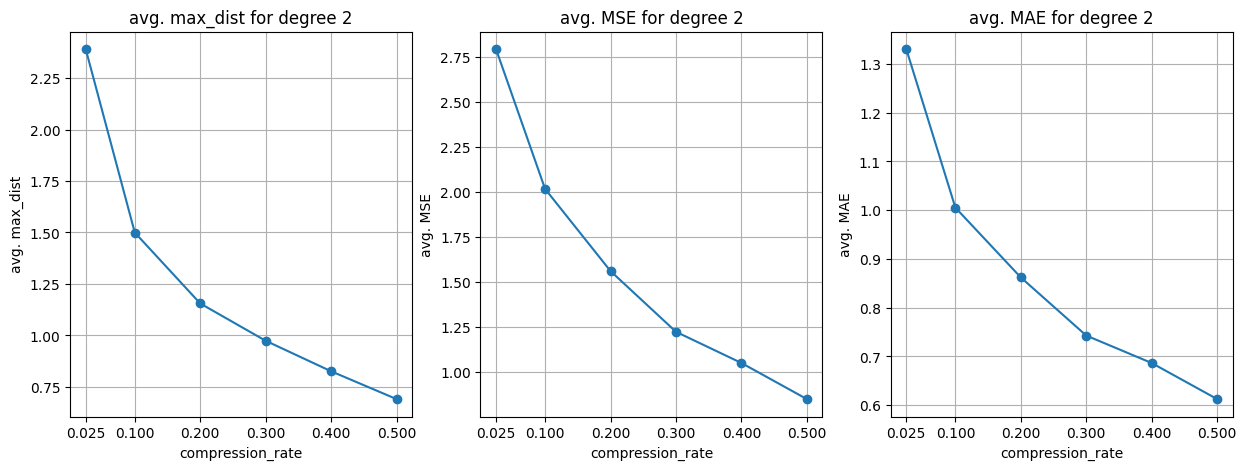

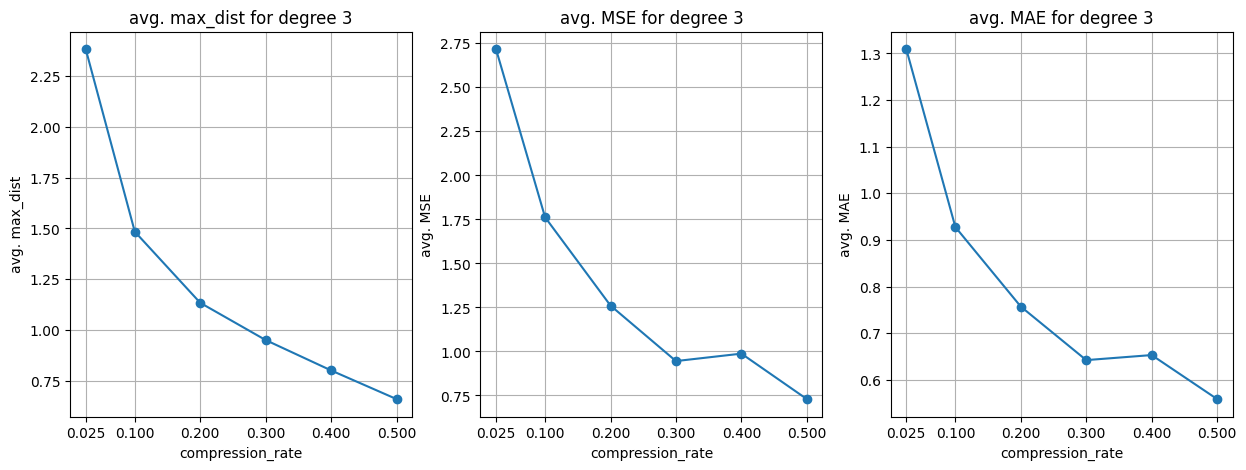

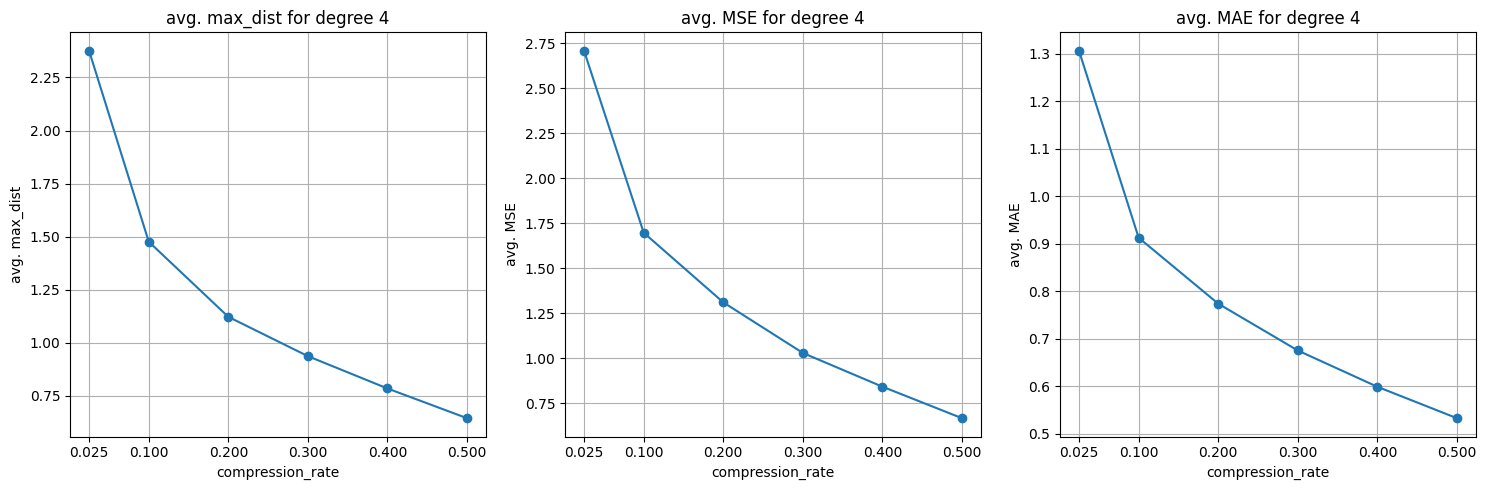

In [16]:
# compression rate vs. avg. accuracy metrics (for each degree)
for degree, group in df.groupby('degree'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    sub_df = df[df['degree'] == degree]
    for i, metric in enumerate(metrics):
        avg_metric_by_compression = sub_df.groupby('compression_rate')[metric].mean()
        print()
        #x= df.groupby('degree')[metric].mean()
        axs[i].plot(avg_metric_by_compression.index, avg_metric_by_compression.values, marker='o', linestyle='-')
        axs[i].set_xlabel('compression_rate')
        axs[i].set_ylabel('avg. ' + metric)
        axs[i].set_title('avg. ' + metric + ' for degree ' + str(degree))
        axs[i].set_xticks(list(avg_metric_by_compression.index))
        axs[i].grid(True)

plt.tight_layout()
plt.show()